<a href="https://colab.research.google.com/github/YinmiAlas/DS-Unit-2-Linear-Models/blob/master/LS_DS_213_Ridge_Regression_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [82]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [83]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [84]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [85]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [86]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [87]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019


In [88]:
# subsetting data
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df = df[df['SALE_PRICE'] >= 100000]
df = df[df['SALE_PRICE'] <= 1000000]
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [89]:
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         2906
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  2905
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [90]:
#splitting data
# adding datime index column to for a esay split
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
datecut = pd.to_datetime('2019-04-01')
sale_date_train = df[df.SALE_DATE < datecut]
sale_date_test  = df[df.SALE_DATE >= datecut]


sale_date_train.shape, sale_date_test.shape

((2316, 21), (590, 21))

In [91]:
sale_date_train.describe(include='number')

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2316.000000,2316.000000,0.0,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.0,2316.000000
mean,6878.294905,76.487478,NaN,10976.379534,0.986615,0.011226,0.997841,1406.343696,1945.332470,1.0,558129.688256
std,4026.486996,153.119875,NaN,503.252098,0.114942,0.105380,0.156899,506.636139,26.896875,0.0,199669.553231
min,21.000000,1.000000,NaN,10301.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,100000.000000
25%,3885.500000,21.000000,NaN,10314.000000,1.000000,0.000000,1.000000,1125.000000,1925.000000,1.0,425000.000000
50%,6028.500000,42.000000,NaN,11234.000000,1.000000,0.000000,1.000000,1333.000000,1940.000000,1.0,540000.000000
75%,10353.000000,70.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1610.500000,1960.000000,1.0,687472.000000
max,16350.000000,2720.000000,NaN,11697.000000,1.000000,1.000000,2.000000,7500.000000,2018.000000,1.0,999999.000000


In [92]:
sale_date_train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2316,2316,2316,2316,2316,2316,1,2316,2316,2316
unique,5,7,1,2,12,2307,1,823,10,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,216-29 114TH ROAD,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1111,2194,2316,2285,829,2,1,218,829,73
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [126]:
# x matrices and y vectors
target = 'SALE_PRICE'
excluding = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE', 'APARTMENT_NUMBER', 'TAX_CLASS_AT_PRESENT']               
features = sale_date_train.columns.drop([target] + excluding)

sale_date_train_x = sale_date_train[features]

sale_date_train_y = sale_date_train[target]

sale_date_test_x = sale_date_test[features]

sale_date_test_y = sale_date_test[target]

sale_date_train_x.shape, sale_date_test_y.shape

((2316, 15), (590,))

In [100]:
# one-hot-encoding
import category_encoders as ce 

categorical_encoder = ce.OneHotEncoder(use_cat_names=True)

train_X_encoder = categorical_encoder.fit_transform(sale_date_train_x)
test_X_encoder = categorical_encoder.transform(sale_date_test_x)

train_X_encoder.head(2)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_A3
44,1,0,0,0,0,1,0,0,0,0,0,0,1,5495,801,NaN,1,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,0,1,7918,72,NaN,0,1,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0


In [102]:
train_X_encoder.shape

(2316, 45)

In [111]:
#imputer data 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(train_X_encoder)
X_test_imputed = imputer.transform(test_X_encoder)

# when i impute data convert to numpar array 
# so i gotta convert it back to pandas DataFrame
X_train_imputed = pd.DataFrame(X_train_imputed)
X_test_imputed = pd.DataFrame(X_test_imputed)

X_train_imputed.shape, X_test_imputed.shape


((2316, 44), (590, 44))

In [113]:
# fitting and take out the MAE with Linear Regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train_imputed.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)

    X_train_selected = selector.fit_transform(X_train_imputed, sale_date_train_y)
    X_test_selected = selector.transform(X_test_imputed)

    model = LinearRegression()
    model.fit(X_train_selected, sale_date_train_y)

    y_pred = model.predict(X_test_selected)

    mae = mean_absolute_error(sale_date_test_y, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $145,910 

2 features
Test Mean Absolute Error: $141,576 

3 features
Test Mean Absolute Error: $138,985 

4 features
Test Mean Absolute Error: $139,187 

5 features
Test Mean Absolute Error: $138,698 

6 features
Test Mean Absolute Error: $138,803 

7 features
Test Mean Absolute Error: $134,985 

8 features
Test Mean Absolute Error: $134,801 

9 features
Test Mean Absolute Error: $134,801 

10 features
Test Mean Absolute Error: $134,412 

11 features
Test Mean Absolute Error: $133,258 

12 features
Test Mean Absolute Error: $125,285 

13 features
Test Mean Absolute Error: $126,064 

14 features
Test Mean Absolute Error: $126,064 

15 features
Test Mean Absolute Error: $126,064 

16 features
Test Mean Absolute Error: $125,367 

17 features
Test Mean Absolute Error: $125,367 

18 features
Test Mean Absolute Error: $126,064 

19 features
Test Mean Absolute Error: $125,702 

20 features
Test Mean Absolute Error: $125,760 

21 features
Test Mean Absolut

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

Test Mean Absolute Error: $125,534 

26 features
Test Mean Absolute Error: $125,815 

27 features
Test Mean Absolute Error: $125,824 

28 features
Test Mean Absolute Error: $125,223 

29 features
Test Mean Absolute Error: $125,223 

30 features
Test Mean Absolute Error: $124,717 

31 features
Test Mean Absolute Error: $124,720 

32 features
Test Mean Absolute Error: $124,720 

33 features
Test Mean Absolute Error: $124,709 

34 features
Test Mean Absolute Error: $124,709 

35 features
Test Mean Absolute Error: $126,062 

36 features
Test Mean Absolute Error: $126,082 

37 features
Test Mean Absolute Error: $126,078 

38 features
Test Mean Absolute Error: $126,056 

39 features
Test Mean Absolute Error: $126,069 

40 features
Test Mean Absolute Error: $126,061 

41 features
Test Mean Absolute Error: $126,063 

42 features
Test Mean Absolute Error: $126,065 

43 features
Test Mean Absolute Error: $126,073 

44 features
Test Mean Absolute Error: $126,056 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

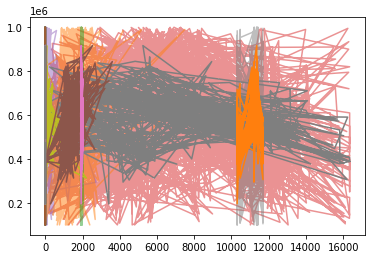

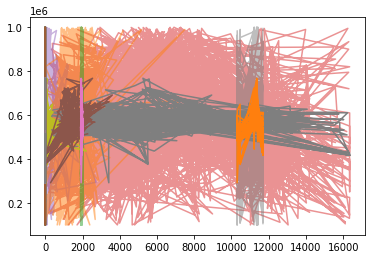

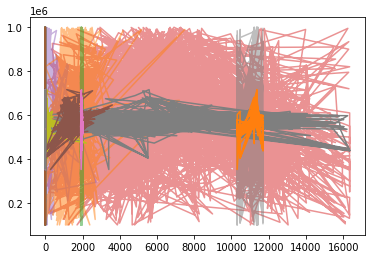

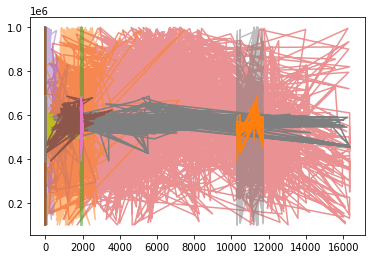

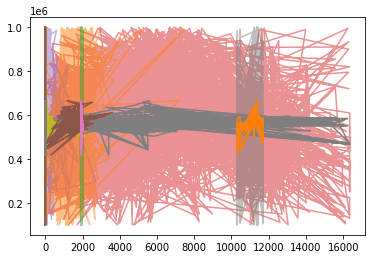

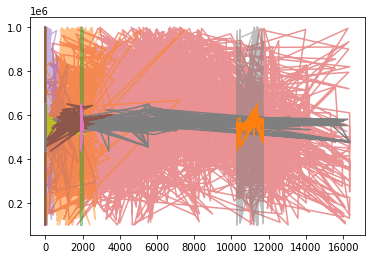

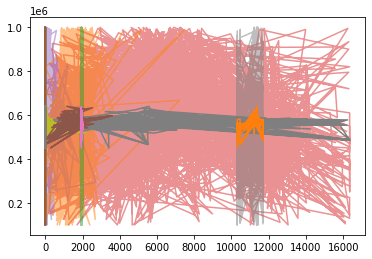

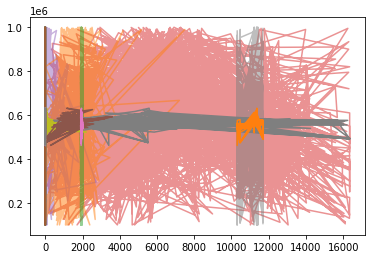

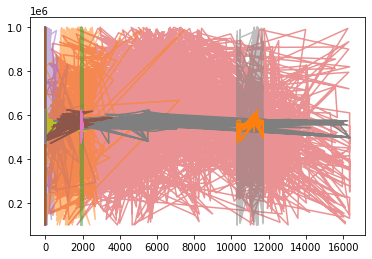

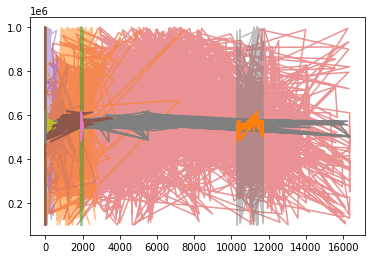

In [152]:
# fitting and take out the MAE with Ridge Regression

from sklearn.linear_model import Ridge
from IPython.display import display, HTML
import matplotlib.pyplot as plt

for alpha in range(10):

   # Fit Ridge Regression model

    display(HTML(f'Ridge Regression, with alpha={alpha}'))

    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_imputed, sale_date_train_y)
    
    # Get Test MAE
    y_pred = model.predict(X_test_imputed)

    mae = mean_absolute_error(sale_date_test_y, y_pred)
    
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    plt.plot(X_train_imputed, sale_date_train_y, alpha=0.5)
    plt.plot(X_test_imputed, y_pred)
    plt.show()

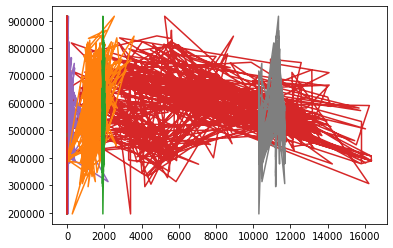

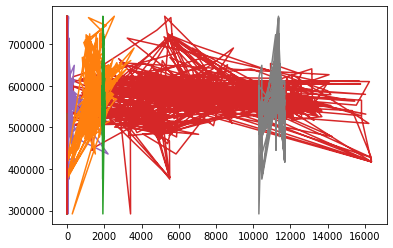

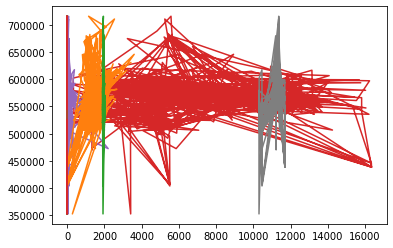

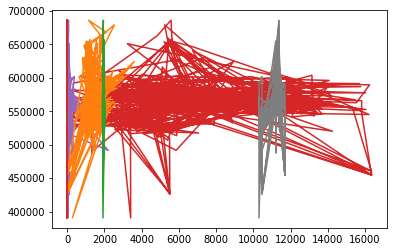

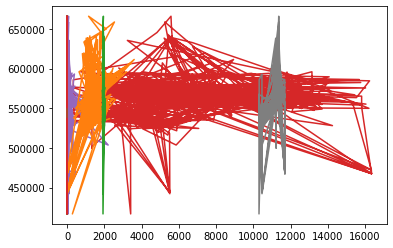

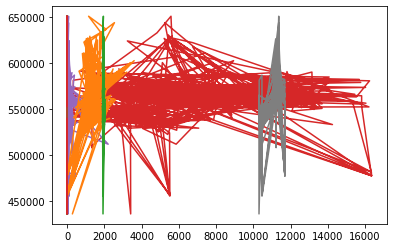

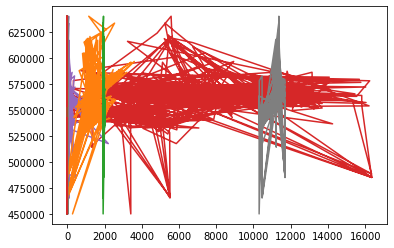

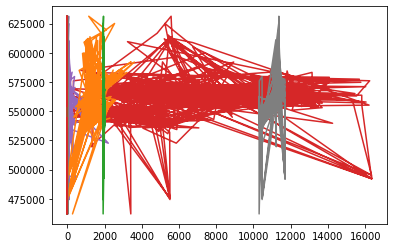

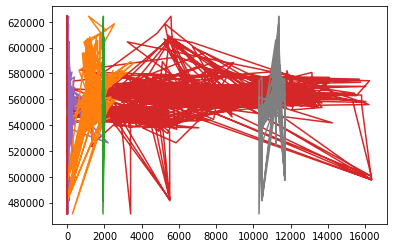

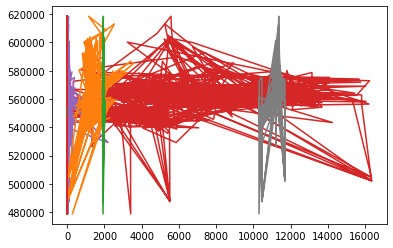

In [151]:
# fitting and take out the MAE with Ridge Regression

from sklearn.linear_model import Ridge
from IPython.display import display, HTML
import matplotlib.pyplot as plt

for alpha in range(10):

   # Fit Ridge Regression model

    display(HTML(f'Ridge Regression, with alpha={alpha}'))

    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_imputed, sale_date_train_y)
    
    # Get Test MAE
    y_pred = model.predict(X_test_imputed)

    mae = mean_absolute_error(sale_date_test_y, y_pred)
    
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    #plt.plot(X_train_imputed, sale_date_train_y, alpha=0.05) redoing RIDGE REGRESSION againg but taking out this part
    plt.plot(X_test_imputed, y_pred)
    plt.show()